In [129]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import root
#from scipy.optimize import minimize
import uncertainties
from scipy.optimize import curve_fit
import seaborn as sns

In [94]:
from scipy.constants import e

## Reading, first calculations from data and adding uncertainties

In [95]:
#einlesen
df=pd.read_csv("data_e092.csv")
df.head()

,R_temp1_ohm,1a_mV,1b_mV,2a_mV,2b_mV,R_temp2_ohm,3a_0_mV,3a_B_mV,3b_B_mV,3b_0_mV
0,108.443,25.673,-25.687,11.630,-11.640,108.442,14.0,3.953,-3.972,-14.017
1,108.442,25.672,-25.688,11.626,-11.637,108.442,14.0,3.955,-3.968,-14.017
2,108.442,25.672,-25.688,11.626,-11.638,108.442,14.0,3.955,-3.996,-14.017
3,108.442,25.673,-25.688,11.627,-11.638,108.442,14.0,3.954,-3.970,-14.016
4,108.442,25.673,-25.687,11.627,-11.638,108.442,14.0,3.954,-3.969,-14.017


In [96]:
#transdencent function for rho
def transcendent_function(f, x):
    return np.cosh(np.log(2)/f * (x-1)/(x+1)) - 0.5*np.exp(np.log(2)/f)

In [97]:
# remove the bad values, i.e. in german: "Ausreißer"
df = df.drop([66-14,66-15,66-16,66-17,66-18, 66-22, 66-25])

In [98]:
df = df.reset_index()

In [99]:
#temperature with uncertainty
def get_temp_uncert(T):
    new_T=[]
    for t in range(len(T)):
        if T[t]>70:
            new_T.append(uncertainties.ufloat(T[t], abs(T[t])*0.002))
        else:
            new_T.append(uncertainties.ufloat(T[t], abs(T[t])*0.01))
    return np.array(new_T)
#define thickness
d = uncertainties.ufloat(500e-6, 1e-6)
#temperature conversion in K
T_1 = 509/8 - 89/2/df["R_temp1_ohm"] + 43/30*np.sqrt(df["R_temp1_ohm"]) + 161/113*df["R_temp1_ohm"]**1.1
T_2 = 509/8 - 89/2/df["R_temp2_ohm"] + 43/30*np.sqrt(df["R_temp2_ohm"]) + 161/113*df["R_temp2_ohm"]**1.1
#adding uncertainties to temperature
T_1=get_temp_uncert(T_1)
T_2=get_temp_uncert(T_2)

In [100]:
#define the voltages and add uncertainty of 0.5
def get_uncertainty_function(array):
    new_array=[]
    for i in range(len(array)):
        new_array.append(uncertainties.ufloat(array[i], 0.05)) #adding uncertainty of 0.05mV
    return np.array(new_array)

#voltages in mV
U_1a = get_uncertainty_function(df["1a_mV"])
U_1b = get_uncertainty_function(df["1b_mV"])
U_2a = get_uncertainty_function(df["2a_mV"])
U_2b = get_uncertainty_function(df["2b_mV"])
U_3a_0 = get_uncertainty_function(df["3a_0_mV"])
U_3b_0 = get_uncertainty_function(df["3b_0_mV"])
U_3a_B = get_uncertainty_function(df["3a_B_mV"])
U_3b_B = get_uncertainty_function(df["3b_B_mV"])

#current
I=uncertainties.ufloat(500e-3, ((1.05/100)*500e-3) + 1e-3) #in mA

#magnetic field
B=uncertainties.ufloat(252.5e-3, 0.5e-3) #in mT

### Uncertainty of f
The uncertainty needs to be calculated in alternative way since solving of the transcedental equation gives no uncertainty
Approximating uncertainty through: 

$\Delta f = f \frac{\Delta x}{x}$

In [101]:
#compute the resistance
rho1=[]
for i in range(len(df["R_temp1_ohm"])):
    #Current of 500uA = 0.5mA
    R_abcd = (abs(U_1a[i]/I) + abs(U_1b[i]/(-I)))/2 #both current directions
    R_bcda = (abs(U_2a[i]/I) + abs(U_2b[i]/(-I)))/2 #both current directions
    x=R_abcd/R_bcda #here we need to take nominal value, otherwise cant solve equation
    f = root(transcendent_function, 0.5, args=(x.n, )).x[0] #finding solution for the transcendent equation
    f_uncert = f*x.s/x.n
    f=uncertainties.ufloat(f, f_uncert)
    rho1.append(np.pi * d / np.log(2) *0.5*(R_abcd+R_bcda)*f) #calculating rho in SI units
    rho = np.array(rho1)

In [102]:
#calculating Hall's coefficient
R_acbd_a = U_3a_B/I
R_acbd_b = U_3b_B/(-I)
R_H_1 = d/B * (R_acbd_a - U_3a_0/I)
R_H_2 = d/B * (R_acbd_b - U_3b_0/(-I))
R_H = (R_H_1+R_H_2)/2

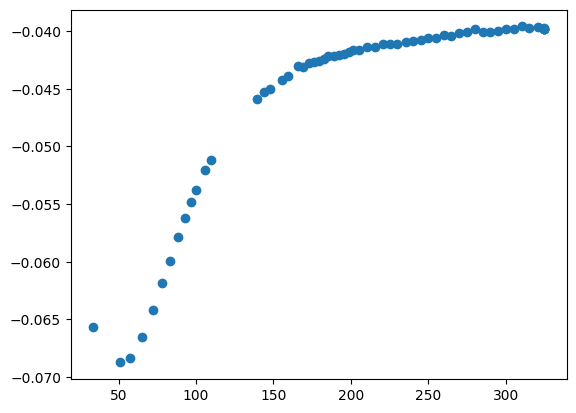

In [103]:
plt.scatter(np.array([T_2[i].n for i in range(len(T_2))]), np.array([R_H[i].n for i in range(len(R_H))]))

## Room temperature

In [104]:
df_RT = df[0:5]
df_RT

,index,R_temp1_ohm,1a_mV,1b_mV,2a_mV,2b_mV,R_temp2_ohm,3a_0_mV,3a_B_mV,3b_B_mV,3b_0_mV
0,0,108.443,25.673,-25.687,11.630,-11.640,108.442,14.0,3.953,-3.972,-14.017
1,1,108.442,25.672,-25.688,11.626,-11.637,108.442,14.0,3.955,-3.968,-14.017
2,2,108.442,25.672,-25.688,11.626,-11.638,108.442,14.0,3.955,-3.996,-14.017
3,3,108.442,25.673,-25.688,11.627,-11.638,108.442,14.0,3.954,-3.970,-14.016
4,4,108.442,25.673,-25.687,11.627,-11.638,108.442,14.0,3.954,-3.969,-14.017


In [105]:
Temp1_RT = T_1[0:5]
Temp2_RT = T_2[0:5]
R_H_RT = R_H[0:5]
rho_RT=rho[0:5]

In [106]:
Temp1_RT

array([325.01125155832574+/-0.6500225031166514,
       325.00867480535675+/-0.6500173496107136,
       325.00867480535675+/-0.6500173496107136,
       325.00867480535675+/-0.6500173496107136,
       325.00867480535675+/-0.6500173496107136], dtype=object)

In [107]:
Temp2_RT

array([325.00867480535675+/-0.6500173496107136,
       325.00867480535675+/-0.6500173496107136,
       325.00867480535675+/-0.6500173496107136,
       325.00867480535675+/-0.6500173496107136,
       325.00867480535675+/-0.6500173496107136], dtype=object)

In [108]:
R_H_RT

array([-0.03978613861386139+/-0.0005468861446207295,
       -0.03979009900990099+/-0.0005469334459398954,
       -0.039734653465346534+/-0.0005462712837048043,
       -0.039786138613861384+/-0.0005468861446207294,
       -0.03979009900990099+/-0.0005469334459398955], dtype=object)

In [109]:
rho_RT

array([0.08024101354828662+/-0.0010559383973297992,
       0.08023039610963874+/-0.0010558166452383287,
       0.08023191296299605+/-0.0010558340387555967,
       0.08023430488027235+/-0.0010558625763916845,
       0.08023342979088136+/-0.0010558514321524326], dtype=object)

In [110]:
n_RT = 1/(R_H_RT*(-e))
mu_RT = -R_H_RT/rho_RT

In [111]:
n_RT

array([1.568764723572907e+20+/-2.1563683267138895e+18,
       1.56860858097078e+20+/-2.1561255635673592e+18,
       1.5707974098488417e+20+/-2.1595293847640067e+18,
       1.5687647235729074e+20+/-2.15636832671389e+18,
       1.56860858097078e+20+/-2.1561255635673595e+18], dtype=object)

In [112]:
mu_RT

array([0.4958329519344779+/-0.0031986961734799574,
       0.4959479316981794+/-0.0031994749726206332,
       0.49524748940826885+/-0.0031975777393775506,
       0.49587441024423734+/-0.003199120738998844,
       0.4959291795652888+/-0.0031992892425015134], dtype=object)

## Temperature series

In [113]:
n = 1/(R_H*(-e))

In [114]:
mu = -R_H/rho

### plot+fit ln(n) vs 1/T

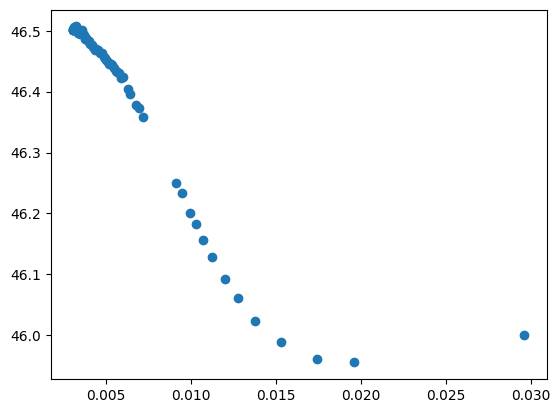

In [115]:
#plot
plt.scatter(1/np.array([T_2[i].n for i in range(len(T_2))]), np.log(np.array([n[i].n for i in range(len(n))])))

In [116]:
#fitting
def high_temp_fit(T_2, a_h, b_h): #this is on the left side
    return a_h * T_2 + b_h

#def low_temp_fit(x, const): #constant fit
    #return x*const

def get_temp_range(T, l, h):
    new_T=[]
    position=[]
    for t in range(len(T)):
        if T[t].n<=h and T[t].n>=l:
            new_T.append(T[t])
            position.append(t)
    return np.array(new_T), np.array(position)

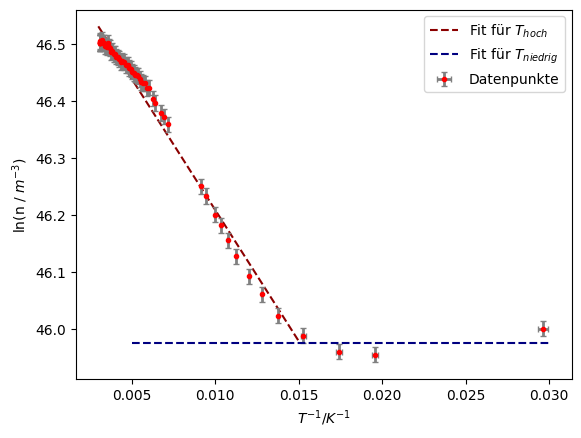

In [135]:
#fit+plot
import uncertainties.umath

#defining inverse temperatures and log of n(needed for uncertainties)
inverse_temps=1/T_2
high_temp_range = get_temp_range(inverse_temps, 0, 0.014) #[0] are the inverse temps in the range, [1] are the index
n_log=[]
for i in range(len(n)):
    n_log.append(uncertainties.umath.log(n[i]))
n_log=np.array(n_log)

#for higher temperatures or lower 1/T
popt, pcov = curve_fit(high_temp_fit, np.array([high_temp_range[0][i].n for i in range(len(high_temp_range[0]))]),
                       np.array([n_log[i].n for i in high_temp_range[1]]), sigma=np.array([n_log[i].s for i in high_temp_range[1]]))
plt.plot(np.linspace(0.003, 0.015, 1000), high_temp_fit(np.linspace(0.003, 0.015, 1000), popt[0], popt[1]), label=r"Fit für $T_{hoch}$", color="darkred", ls = "--")
plt.errorbar(np.array([inverse_temps[i].n for i in range(len(inverse_temps))]),  np.array([n_log[i].n for i in range(len(n))]),
             yerr= np.array([n_log[i].s for i in range(len(n))]), xerr=np.array([inverse_temps[i].s for i in range(len(inverse_temps))]), ls='none', capsize=2,
             label="Datenpunkte", color="red", ecolor="gray", elinewidth = 2, fmt=".")
#plt.scatter(1/np.array([T_2[i].n for i in range(len(T_2))]), np.log(np.array([n[i].n for i in range(len(n))])))
a_h=uncertainties.ufloat(popt[0], np.sqrt(pcov[0][0]))
b_h=uncertainties.ufloat(popt[1], np.sqrt(pcov[1][1]))

#for lower temperatures or higher 1/T
low_temp_range = get_temp_range(inverse_temps, 0.014, 0.1)
x_p=np.poly1d(np.polyfit(np.array([low_temp_range[0][i].n for i in range(len(low_temp_range[0]))]), np.log(np.array([n[i].n for i in low_temp_range[1]])), 0))
#popt, pcov = curve_fit(low_temp_fit, low_temp_range[0], np.log(np.array([n[i].n for i in low_temp_range[1]])), sigma=np.log(np.array([n[i].s for i in low_temp_range[1]])))
#TODO: plot error bars and axis
plt.plot(np.linspace(0.005, 0.030, 1000), x_p(np.linspace(0.005, 0.030, 1000)), label=r"Fit für $T_{niedrig}$", color="navy", ls = "--")
plt.legend()
plt.xlabel(r"$T^{-1} / K^{-1}$")
plt.ylabel(r"ln(n / $m^{-3}$)")
plt.savefig("invT_vs_n.png", dpi=500)
plt.show()


In [118]:
print("High temperatures: a_h=", a_h, " b_h=", b_h)
print("Low temperatures: const=", x_p)
print("Mean of lower temperatures:", np.log(np.array([n[i].n for i in low_temp_range[1]])).mean())
print("Standard deviation of lower temperatures:", np.log(np.array([n[i].n for i in low_temp_range[1]])).std())
#Maybe this method better as we get an uncertainty

High temperatures: a_h= -46.0+/-0.9  b_h= 46.669+/-0.005
Low temperatures: const=  
45.98
Mean of lower temperatures: 45.97634547460399
Standard deviation of lower temperatures: 0.01901619727007909


In [128]:
cn=uncertainties.ufloat(np.log(np.array([n[i].n for i in low_temp_range[1]])).mean(), np.log(np.array([n[i].n for i in low_temp_range[1]])).std())
charge_carrier_denisty = uncertainties.umath.exp(cn)
print(charge_carrier_denisty)

(9.27+/-0.18)e+19


In [119]:
#ionisation energy
from scipy.constants import k
E_d = -2*a_h*k / 1.6e-19 #in eV
print("Ionization energy =", E_d*1000, "meV") #in meV

Ionization energy = 7.93+/-0.15 meV


### plot+fit ln(mu) vs 1/T

In [120]:
T_gen = (T_1 + T_2)/2

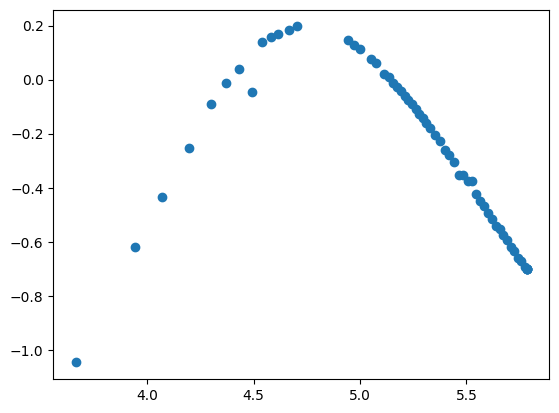

In [121]:
#plot
plt.scatter(np.log(np.array([T_gen[i].n for i in range(len(T_gen))])), np.log(np.array([mu[i].n for i in range(len(mu))])))

In [122]:
#fitting
def temp_fit(ln_T, a_h, b_h): #this is on the left side
    return a_h * ln_T + b_h

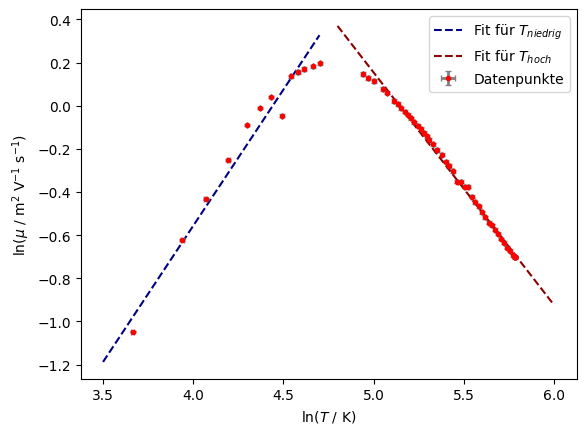

In [137]:
#fit+plot
temps=[]
mu_log=[]
for i in range(len(mu)):
    mu_log.append(uncertainties.umath.log(mu[i]))
    temps.append(uncertainties.umath.log(T_gen[i]))
mu_log=np.array(mu_log)
temps=np.array(temps)
temp_range = get_temp_range(temps, 0, 4.8) #[0] are the inverse temps in the range, [1] are the index

popt, pcov = curve_fit(temp_fit, np.array([temp_range[0][i].n for i in range(len(temp_range[0]))]),
                       np.array([mu_log[i].n for i in temp_range[1]]), sigma=np.array([mu_log[i].s for i in temp_range[1]]))
plt.plot(np.linspace(3.5, 4.7, 1000), temp_fit(np.linspace(3.5, 4.7, 1000), popt[0], popt[1]), color="navy", label=r"Fit für $T_{niedrig}$", ls = "--")
plt.errorbar(np.array([temps[i].n for i in range(len(temps))]),  np.array([mu_log[i].n for i in range(len(temps))]),
             yerr= np.array([mu_log[i].s for i in range(len(temps))]), xerr=np.array([temps[i].s for i in range(len(temps))]), ls='none', 
             label="Datenpunkte", ecolor="gray", elinewidth = 2, capsize = 2, color="red", fmt=".")
a_blue = uncertainties.ufloat(popt[0], np.sqrt(pcov[0][0]))
b_blue = uncertainties.ufloat(popt[1], np.sqrt(pcov[1][1]))


temp_range = get_temp_range(temps, 4.8, 7)
popt, pcov = curve_fit(temp_fit, np.array([temp_range[0][i].n for i in range(len(temp_range[0]))]),
                       np.array([mu_log[i].n for i in temp_range[1]]), sigma=np.array([mu_log[i].s for i in temp_range[1]]))
plt.plot(np.linspace(4.8, 6, 1000), temp_fit(np.linspace(4.8, 6, 1000), popt[0], popt[1]), label=r"Fit für $T_{hoch}$", color="darkred", ls = "--")
plt.errorbar(np.array([temps[i].n for i in range(len(temps))]),  np.array([mu_log[i].n for i in range(len(mu))]),
             yerr= np.array([mu_log[i].s for i in range(len(mu))]), xerr=np.array([temps[i].s for i in range(len(temps))]), ls='none', color="steelblue", capsize=1)
a_orange = uncertainties.ufloat(popt[0], np.sqrt(pcov[0][0]))
b_orange = uncertainties.ufloat(popt[1], np.sqrt(pcov[1][1]))

plt.xlabel(r"ln($T$ / K)")
plt.ylabel(r"ln($\mu$ / m$^2$ V$^{-1}$ s$^{-1}$)")
plt.legend()
plt.savefig("lnT_vs_lnMu.png", dpi=500)
plt.show()

In [88]:
print("Blue: a_blue=", a_blue, " b_blue=", b_blue)
print("Orange: a_orange=", a_orange, " b_orange=", b_orange)

Blue: a_blue= 1.26+/-0.06  b_blue= -5.61+/-0.26
Orange: a_orange= -1.078+/-0.011  b_orange= 5.54+/-0.06
